In [1]:
#Import 
import warnings; warnings.simplefilter('ignore') #for PCoA warnings
import pandas as pd
import numpy as np

#import data
from biom import load_table
from gneiss.util import match

#plotting
import seaborn as sns
import matplotlib.pyplot as plt

#completions
from DEICODE.optspace import OptSpace
from DEICODE.GaPNMF import GaPNMF
from fancyimpute import KNN,SoftImpute,IterativeSVD,MatrixFactorization
from DEICODE.untangle import machine_learning

#transforms 
from skbio.stats.composition import ilr

#splits 
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

# Intials
rand = np.random.RandomState(42)
fnts=12

# make it look nice
sns.set(font="monospace")
#make the text readable
from IPython.core.display import HTML
plt.style.use('fivethirtyeight')
plt.style.use('seaborn-white')
plt.style.use('seaborn-darkgrid')
plt.style.use('seaborn-paper')
HTML("""<style>div.cell { /* Tunes the space between cells */margin-top:1em;margin-bottom:1em;}div.text_cell_render h1 { /* Main titles bigger, centered */
font-size: 3em;line-height:1.4em;text-align:center;}
div.text_cell_render h2 { /*  Parts names nearer from text */margin-bottom: -0.4em;}
div.text_cell_render { /* Customize text cells */font-family: 'Times New Roman';font-size:1.2em;line-height:1.4em;
padding-left:3em;padding-right:3em;}</style>""")
%matplotlib inline

Instructions for updating:
Use the retry module or similar alternatives.


Using TensorFlow backend.


# Import the datasets 

In [2]:
# import keyboard observation data
in_biom='data/benchmarking/keyboard.biom' #import biom file
table = load_table(in_biom)
sample_filter = lambda val, id_, md: sum(val) > 0
table = table.filter(sample_filter, axis='sample')
otutabledf=table.to_dataframe()
otutabledf=otutabledf.T
otutabledf.drop_duplicates(inplace=True)

# Get OTU to taxa match
taxonomy=table.metadata_to_dataframe('observation')
taxonomy.columns=['kingdom', 'phylum', 'class', 'order', 
                             'family', 'genus', 'species']
taxonomy['taxonomy'] = taxonomy[taxonomy.columns].apply(lambda x: ';'.join(x), axis=1)

#mapping import 
map_file='data/benchmarking/keyboard.txt' #import metadata
mappingdf= pd.read_table('%s'%map_file, index_col=0,low_memory=False)
mappingdf=mappingdf.replace(np.nan,'Unknown', regex=True)
mappingdf.index=list(map(str,mappingdf.index))
mappingdf=mappingdf.astype(str)
mappingdf=mappingdf[~mappingdf.index.duplicated(keep='first')]

#match the tables
otu_keyboard,mapping_keyboard=match(otutabledf,mappingdf[mappingdf['host_subject_id'].isin(['M2','M3','M9'])])
mapping_keyboard=mapping_keyboard.apply(pd.to_numeric, errors='ignore')
mapping_keyboard_class=mapping_keyboard.copy()
mapping_keyboard=mapping_keyboard.apply(preprocessing.LabelEncoder().fit_transform)

In [ ]:
# import 88 soils observation data
in_biom='data/benchmarking/88soils.biom' #import biom file
table = load_table(in_biom)
sample_filter = lambda val, id_, md: sum(val) > 0
table = table.filter(sample_filter, axis='sample')
#table.filter(read_filter, axis='observation')
otutabledf=table.to_dataframe()
otutabledf=otutabledf.T
otutabledf.drop_duplicates(inplace=True)

# Get OTU to taxa match
taxonomy=table.metadata_to_dataframe('observation')
taxonomy.columns=['kingdom', 'phylum', 'class', 'order', 
                             'family', 'genus', 'species']
taxonomy['taxonomy'] = taxonomy[taxonomy.columns].apply(lambda x: ';'.join(x), axis=1)

#mapping import 
map_file='data/benchmarking/88soils.txt' #import metadata
mappingdf= pd.read_table('%s'%map_file, index_col=0,low_memory=False)
mappingdf=mappingdf.replace(np.nan,'Unknown', regex=True)
mappingdf.index=list(map(str,mappingdf.index))
mappingdf=mappingdf.astype(str)
mappingdf=mappingdf[~mappingdf.index.duplicated(keep='first')]

#match the tables
otu_soils,mapping_soils=match(otutabledf,mappingdf)
mapping_soils=mapping_soils.apply(pd.to_numeric, errors='ignore')

In [ ]:

# import Sponge observation data

in_biom='data/benchmarking/Thomas_sponge_communities.biom' #import biom file
table = load_table(in_biom)
sample_filter = lambda val, id_, md: sum(val) > 0
table = table.filter(sample_filter, axis='sample')
otutabledf=table.to_dataframe()
otutabledf=otutabledf.T
otutabledf.drop_duplicates(inplace=True)

# Get OTU to taxa match
taxonomy=table.metadata_to_dataframe('observation')
taxonomy.columns=['kingdom', 'phylum', 'class', 'order', 
                             'family', 'genus', 'species']
taxonomy['taxonomy'] = taxonomy[taxonomy.columns].apply(lambda x: ';'.join(x), axis=1)

#mapping import 
map_file='data/benchmarking/Thomas_sponge_communities.txt' #import metadata
mappingdf= pd.read_table('%s'%map_file, index_col=0,low_memory=False)
mappingdf=mappingdf.replace(np.nan,'Unknown', regex=True)
mappingdf.index=list(map(str,mappingdf.index))
#mappingdf.drop(['Color Description','Anonymized Name'],axis=1,inplace=True)
mappingdf=mappingdf.astype(str)
mappingdf=mappingdf[~mappingdf.index.duplicated(keep='first')]

#match the tables
otutabledf_Sponge,mappingdf_Sponge=match(otutabledf,mappingdf)
otutabledf_Sponge,mappingdf_Sponge=match(otutabledf,
                                         mappingdf_Sponge[~mappingdf_Sponge['Life Stage'].isin(['Unknown','Adult'])])
mappingdf_Sponge['Life_Stage']=mappingdf_Sponge['Life Stage'].values
mappingdf_Sponge['Salinity']=mappingdf_Sponge['Salinity'].values
mappingdf_Sponge['Life_Stage']=mappingdf_Sponge['Life Stage'].values
mappingdf_Sponge['Host_Name']=mappingdf_Sponge['Host Name'].values
mappingdf_Sponge_class=mappingdf_Sponge.copy()
mappingdf_Sponge=mappingdf_Sponge.apply(preprocessing.LabelEncoder().fit_transform)

# learning metadata

In [ ]:
# run machine leanring on all of the samples with 100 iterations of splits of 80:20

all_scores_df=[]
for X_train,meta in zip([otutabledf_Sponge,otu_soils,otu_keyboard]
                        ,[mappingdf_Sponge_class[['Life Stage']]
                          ,mapping_soils[['ph']],
                         mapping_keyboard_class[['host_subject_id']]]):
    
    la={}
    
    la['org']=(machine_learning(X_train.T,meta)[0])
    
    #psuedo count
    la['Pseudo Count']=(machine_learning(X_train.T+1,meta)[0])
    
    # OptSpace
    X_filled_opt=OptSpace(X_train.as_matrix().copy(),rank=20,minval=.01,maxval=1).complete()
    comp_tmp=pd.DataFrame(X_filled_opt,X_train.index,X_train.columns)
    la['Opt Space']=(machine_learning(comp_tmp.T,meta)[0])
    
    
    # Make 0 NaN for fancy impute 
    X_noisefancy=X_train.as_matrix().copy()
    X_noisefancy[X_noisefancy==0]=np.nan
    
    # KNN
    X_filled_knn = KNN(verbose=False,min_value=.01,max_value=1).complete(X_noisefancy)
    comp_tmp=pd.DataFrame(X_filled_knn,X_train.index,X_train.columns)
    la['KNN']=(machine_learning(comp_tmp.T,meta)[0])
    
    #soft impute
    X_filled_softimpute = SoftImpute(verbose=False,min_value=.01,max_value=1).complete(X_noisefancy)
    comp_tmp=pd.DataFrame(X_filled_softimpute,X_train.index,X_train.columns)
    la['Soft Impute']=(machine_learning(comp_tmp.T,meta)[0])
    
    # Iter SVD
    X_filled_iter=IterativeSVD(verbose=False,min_value=.01,max_value=1).complete(X_noisefancy)
    comp_tmp=pd.DataFrame(X_filled_iter,X_train.index,X_train.columns)
    la['Iterative SVD']=(machine_learning(comp_tmp.T,meta)[0]) 
    
    dfs=[]
    for method_,df in la.items():
        df_=df.copy()
        df_.index=[method_+' '+x for x in df_.index]
        dfs.append(df_)
    scores_df=pd.concat(dfs)
    all_scores_df.append(scores_df)
all_scores_df=pd.concat(all_scores_df)

# Split the data and metadata into training (75%) and test (25%) 

In [5]:
# Warning: Takes a few min to run 

# split both datasets (75,25)
train_soils, test_soils = train_test_split(otu_soils,test_size=.25)
train_keyboard, test_keyboard = train_test_split(otu_keyboard,test_size=.25)
train_Sponge, test_Sponge = train_test_split(otutabledf_Sponge,test_size=.25)

#make test and train metadata and match to other df for soils dataset 
train_soils,mapping_train_soils=match(train_soils,mapping_soils)
test_soils,mapping_test_soils=match(test_soils,mapping_soils)

#make test and train metadata and match to other df for Keyboard dataset 
train_keyboard,mapping_train_keyboard=match(train_keyboard,mapping_keyboard)
test_keyboard,mapping_test_keyboard=match(test_keyboard,mapping_keyboard)

#make test and train metadata and match to other df for Sponge dataset 
train_Sponge,mapping_train_Sponge=match(train_Sponge,mappingdf_Sponge)
test_Sponge,mapping_test_Sponge=match(test_Sponge,mappingdf_Sponge)

# Test all completion methods on the training datasets 

## Output is saved as a list where completed_soils contains all soils datasets and completed_keyboard contains all keyboard datasets 

## The order for each list is :  [Psuedo, OpSpace, KNN, Soft Impute, Iterative SVD]

In [6]:
%%capture capt 
# to prevent a long output from fancy impute 

#save the output in an ordered list 
completed_soils=[]
completed_keyboard=[]
completed_Sponge=[]


for X_train,la in zip([train_soils,train_keyboard,train_Sponge]
                      ,[completed_soils,completed_keyboard,completed_Sponge]):
        
    #psuedo count
    la.append(X_train+1)
    
    # OptSpace
    X_filled_opt=OptSpace(X_train.as_matrix().copy(),rank=10,minval=.01,maxval=1).complete()
    la.append(pd.DataFrame(X_filled_opt,X_train.index,X_train.columns))
    
    # Make 0 NaN for fancy impute 
    X_noisefancy=X_train.as_matrix().copy()
    X_noisefancy[X_noisefancy==0]=np.nan
    
    # KNN
    X_filled_knn = KNN(verbose=False,min_value=.01,max_value=1).complete(X_noisefancy)
    la.append(pd.DataFrame(X_filled_knn,X_train.index,X_train.columns))
    
    #soft impute
    X_filled_softimpute = SoftImpute(verbose=False,min_value=.01,max_value=1).complete(X_noisefancy)
    la.append(pd.DataFrame(X_filled_softimpute,X_train.index,X_train.columns))
    
    # Iter SVD
    X_filled_iter=IterativeSVD(verbose=False,min_value=.01,max_value=1).complete(X_noisefancy)
    la.append(pd.DataFrame(X_filled_iter,X_train.index,X_train.columns))      

# Run regression analysis on training set and take MSE for prediction on test metadata to test set otu values

In [7]:
from gneiss.cluster import gradient_linkage
from gneiss.regression import ols
from gneiss.cluster import correlation_linkage
from gneiss.composition import ilr_transform
from gneiss.balances import balance_basis
from skbio.stats.composition import ilr_inv

# 88 Soils dataset

In [8]:
# run for each completion method soils #

# to save errors 
errors_unique=[]
errors_counts=[]
MSE_=[]
#intials 

#testing set 
mapping_reg=mapping_train_soils.copy()

#training set
counts_test=test_soils.copy()
meta_test=mapping_test_soils.copy()

for counts in completed_soils:

    # build balances 
    tree = correlation_linkage(counts)
    balances = ilr_transform(counts, tree=tree)   

    # run regression 
    model = ols(table=balances,metadata=mapping_reg,formula='ph')
    model.fit()

    # predict on test set metadata and take inverse ilr
    est =model.predict(np.column_stack((np.vstack(np.array(meta_test.ph.values))
                                   ,np.vstack(np.array(meta_test.ph.values)))))
    basis, _ = balance_basis(tree)
    est = ilr_inv(est, basis=basis)

    # perform error calculation 
    for iter_ in range(10):
        
        etable = est.copy()
        n_ = counts.sum(axis=1).values
        for i in range(etable.shape[0]):
            etable[i] = np.random.multinomial(int(n_[i]), est[i].ravel())
        pseudo = np.ravel(counts_test.values-etable)
        unique_tmp, counts_tmp = np.unique(pseudo, return_counts=True)
        if iter_==0:
            errors_unique.append(unique_tmp)
            errors_counts.append(counts_tmp)

        #save MSE
        perr = np.ravel((etable - counts_test.values))
        MSE_.append(np.mean(perr ** 2))

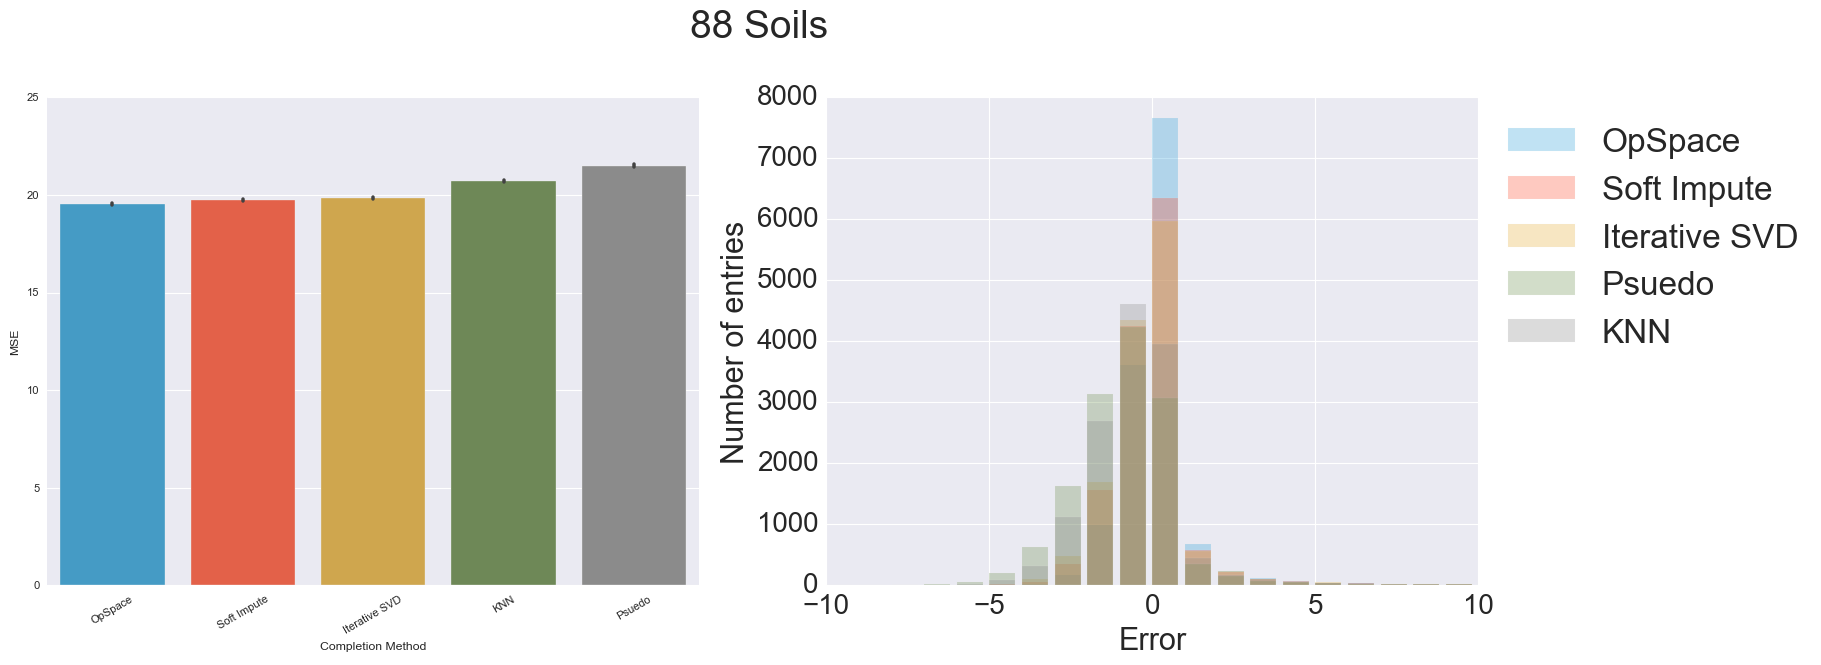

In [9]:
#plot the results 

names_=['OpSpace', 'Soft Impute', 'Iterative SVD', 'Psuedo', 'KNN']
names_order={'Psuedo':0, 'OpSpace':1, 'KNN':2, 'Soft Impute':3, 'Iterative SVD':4}

dfnames_=['Psuedo']*10+['OpSpace']*10+['KNN']*10+['Soft Impute']*10+['Iterative SVD']*10

MSE_data=pd.DataFrame([MSE_,dfnames_]
                      ,['MSE','Completion Method']).T.sort_values('MSE')


MSE_data_soils=MSE_data.copy()

fig, (ax2,ax1) = plt.subplots(ncols=2, nrows=1,figsize=(15,6)) 

for name_ in names_:
    ax1.bar(errors_unique[names_order[name_]], errors_counts[names_order[name_]]
            , alpha=0.3, label=name_,color=next(ax1._get_lines.prop_cycler)['color'])
    
# Set the tick labels font
for label in (ax1.get_xticklabels() + ax1.get_yticklabels()):
    label.set_fontname('Arial')
    label.set_fontsize(20)
    
ax1.legend(loc=2,prop={'size':24},bbox_to_anchor=(1.0, 1.0))
ax1.set_xlim([-10, 10])
ax1.set_xlabel('Error', fontsize=22)
ax1.set_ylabel('Number of entries', fontsize=22)
plt.tight_layout()
#plt.savefig('compare_mse.png')

sns.barplot(x='Completion Method',y='MSE',data=MSE_data,ax=ax2)
for item in ax2.get_xticklabels():
    item.set_rotation(30)

plt.suptitle('88 Soils',y=1.1,fontsize=28)
plt.show()

# Keyboard Dataset

In [10]:
# run for each completion method keyboard #

# to save errors 
errors_unique_keyboard=[]
errors_counts_keyboard=[]
MSE_keyboard=[]
#intials 

#testing set 
mapping_reg=mapping_train_keyboard.copy()

#training set
counts_test=test_keyboard.copy()
meta_test=mapping_test_keyboard.copy()

for counts in completed_keyboard:

    # build balances 
    tree = correlation_linkage(counts)
    balances = ilr_transform(counts, tree=tree)   

    # run regression 
    model = ols(table=balances,metadata=mapping_reg,formula='host_subject_id')
    model.fit()

    # predict on test set metadata and take inverse ilr
    est =model.predict(np.column_stack((np.vstack(np.array(meta_test.host_subject_id.values))
                                   ,np.vstack(np.array(meta_test.host_subject_id.values)))))
    basis, _ = balance_basis(tree)
    est = ilr_inv(est, basis=basis)

    # perform error calculation 
    for iter_ in range(10):
        
        etable = est.copy()
        n_ = counts.sum(axis=1).values
        for i in range(etable.shape[0]):
            etable[i] = np.random.multinomial(int(n_[i]), est[i].ravel())

        pseudo = np.ravel(counts_test.values-etable)
        unique_tmp, counts_tmp = np.unique(pseudo, return_counts=True)
        if iter_==0:
            errors_unique_keyboard.append(unique_tmp)
            errors_counts_keyboard.append(counts_tmp)

        #save MSE
        perr = np.ravel((etable - counts_test.values))
        MSE_keyboard.append(np.mean(perr ** 2))

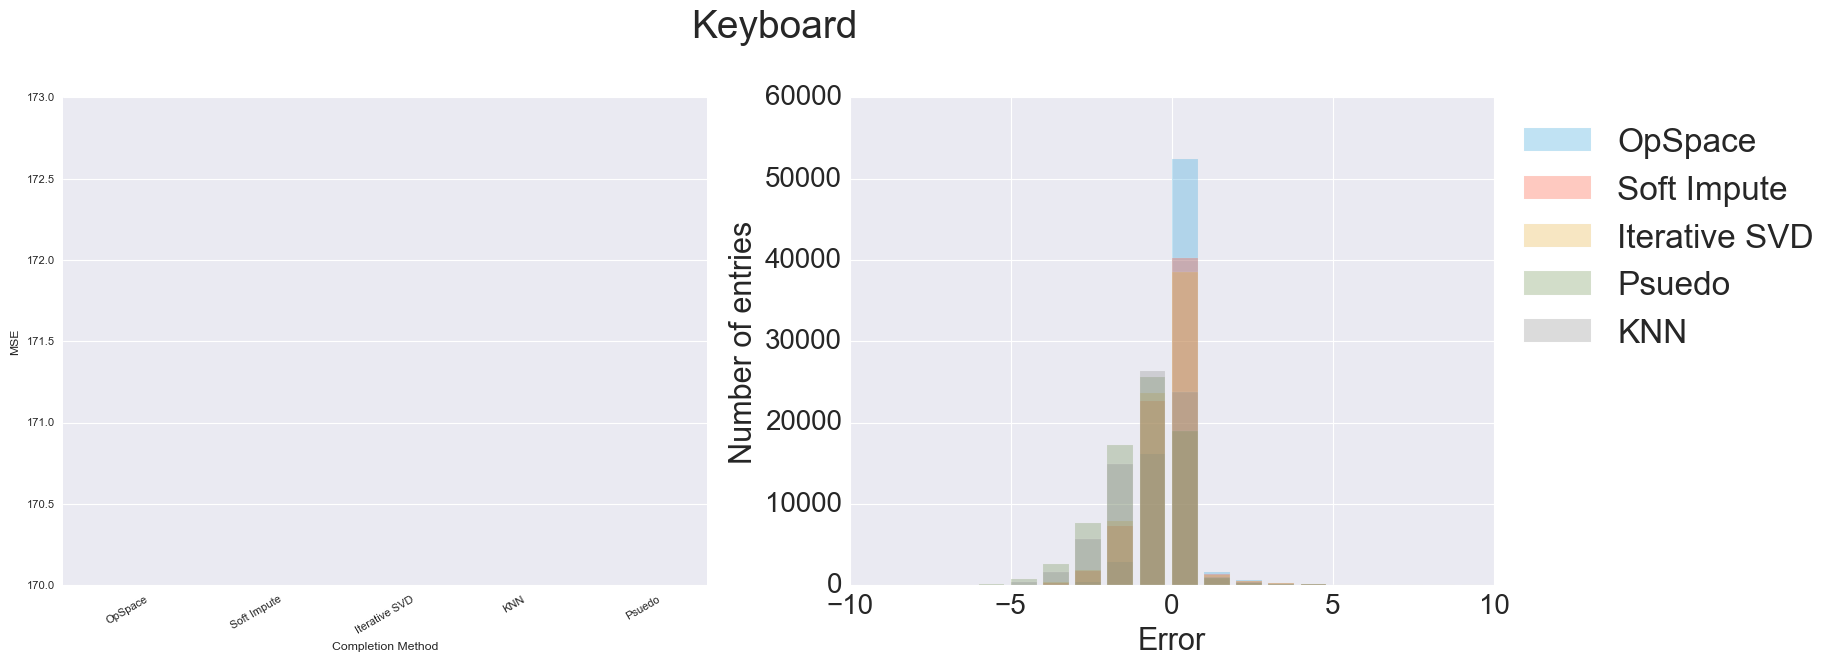

In [11]:
#plot the results 

names_=['OpSpace', 'Soft Impute', 'Iterative SVD', 'Psuedo', 'KNN']
names_order={'Psuedo':0, 'OpSpace':1, 'KNN':2, 'Soft Impute':3, 'Iterative SVD':4}



dfnames_=['Psuedo']*10+['OpSpace']*10+['KNN']*10+['Soft Impute']*10+['Iterative SVD']*10

MSE_keyboarddf=pd.DataFrame([MSE_keyboard,dfnames_]
                      ,['MSE','Completion Method']).T.sort_values('MSE')

MSE_data_keyboard=MSE_keyboarddf.copy()

fig, (ax2,ax1) = plt.subplots(ncols=2, nrows=1,figsize=(15,6)) 

for name_ in names_:
    ax1.bar(errors_unique_keyboard[names_order[name_]], errors_counts_keyboard[names_order[name_]]
            , alpha=0.3, label=name_,color=next(ax1._get_lines.prop_cycler)['color'])
    
# Set the tick labels font
for label in (ax1.get_xticklabels() + ax1.get_yticklabels()):
    label.set_fontname('Arial')
    label.set_fontsize(20)
    
ax1.legend(loc=2,prop={'size':24},bbox_to_anchor=(1.0, 1.0))
ax1.set_xlim([-10, 10])
ax1.set_xlabel('Error', fontsize=22)
ax1.set_ylabel('Number of entries', fontsize=22)
plt.tight_layout()
#plt.savefig('compare_mse.png')

sns.barplot(x='Completion Method',y='MSE',data=MSE_keyboarddf,ax=ax2)
for item in ax2.get_xticklabels():
    item.set_rotation(30)
#ax2.set_ylim([170, 173])
    

plt.suptitle('Keyboard',y=1.1,fontsize=28)
plt.show()

# Sponge

In [12]:
# run for each completion method keyboard #

# to save errors 
errors_unique_Sponge=[]
errors_counts_Sponge=[]
MSE_Sponge=[]
#intials 

#testing set 
mapping_reg=mapping_train_Sponge.copy()

#training set
counts_test=test_Sponge.copy()
meta_test=mapping_test_Sponge.copy()

for counts in completed_Sponge:

    # build balances 
    tree = correlation_linkage(counts)
    balances = ilr_transform(counts, tree=tree)   

    # run regression 
    model = ols(table=balances,metadata=mapping_reg,formula='Life_Stage')
    model.fit()

    # predict on test set metadata and take inverse ilr
    est =model.predict(np.column_stack((np.vstack(np.array(meta_test.Life_Stage.values))
                                   ,np.vstack(np.array(meta_test.Life_Stage.values)))))
    basis, _ = balance_basis(tree)
    est = ilr_inv(est, basis=basis)

    # perform error calculation 
    for iter_ in range(10):
        
        etable = est.copy()
        n_ = counts.sum(axis=1).values
        for i in range(etable.shape[0]):
            etable[i] = np.random.multinomial(int(n_[i]), est[i].ravel())

        pseudo = np.ravel(counts_test.values-etable)
        unique_tmp, counts_tmp = np.unique(pseudo, return_counts=True)
        if iter_==0:
            errors_unique_Sponge.append(unique_tmp)
            errors_counts_Sponge.append(counts_tmp)

        #save MSE
        perr = np.ravel((etable - counts_test.values))
        MSE_Sponge.append(np.mean(perr ** 2))

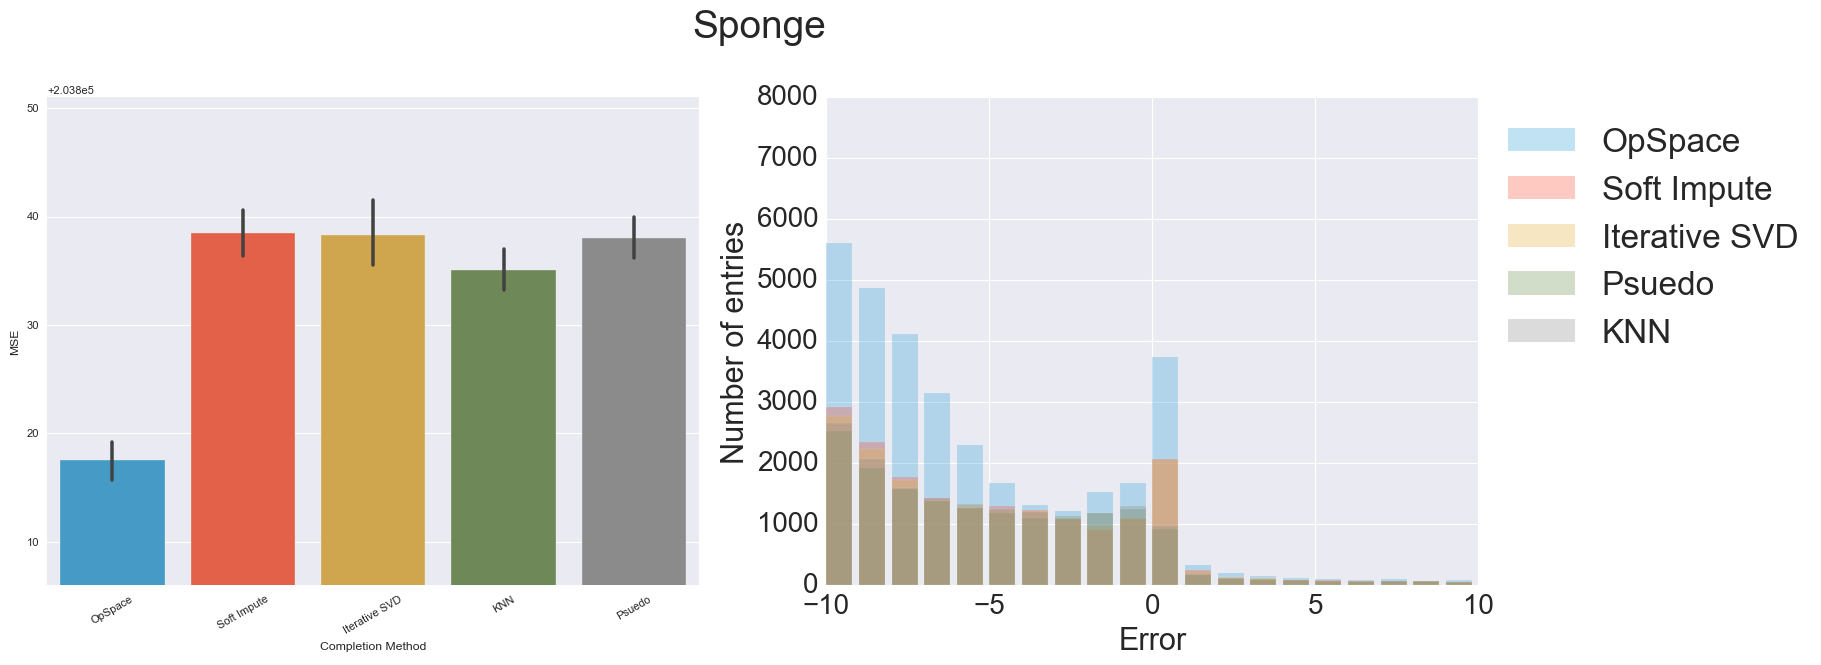

In [32]:
#plot the results 

names_=['OpSpace', 'Soft Impute', 'Iterative SVD', 'Psuedo', 'KNN']
names_order={'Psuedo':0, 'OpSpace':1, 'KNN':2, 'Soft Impute':3, 'Iterative SVD':4}



dfnames_=['Psuedo']*10+['OpSpace']*10+['KNN']*10+['Soft Impute']*10+['Iterative SVD']*10
MSE_sponge=pd.DataFrame([MSE_Sponge,dfnames_]
                      ,['MSE','Completion Method']).T.sort_values('MSE')
order_df={'Psuedo':4, 'OpSpace':0, 'KNN':3, 'Soft Impute':1, 'Iterative SVD':2}
MSE_sponge['sort']=[order_df[x] for x in MSE_sponge['Completion Method']]
MSE_sponge=MSE_sponge.sort_values('sort')

MSE_data_sponge=MSE_sponge.copy()

fig, (ax2,ax1) = plt.subplots(ncols=2, nrows=1,figsize=(15,6)) 

for name_ in names_:
    ax1.bar(errors_unique_Sponge[names_order[name_]], errors_counts_Sponge[names_order[name_]]
            , alpha=0.3, label=name_,color=next(ax1._get_lines.prop_cycler)['color'])
    
# Set the tick labels font
for label in (ax1.get_xticklabels() + ax1.get_yticklabels()):
    label.set_fontname('Arial')
    label.set_fontsize(20)
    
ax1.legend(loc=2,prop={'size':24},bbox_to_anchor=(1.0, 1.0))
ax1.set_xlim([-10, 10])
ax1.set_xlabel('Error', fontsize=22)
ax1.set_ylabel('Number of entries', fontsize=22)
plt.tight_layout()
#plt.savefig('compare_mse.png')

sns.barplot(x='Completion Method',y='MSE',data=MSE_sponge,ax=ax2,ci=60)
for item in ax2.get_xticklabels():
    item.set_rotation(30)
ax2.set_ylim([203806.0, 203851.0])
plt.suptitle('Sponge',y=1.1,fontsize=28)
plt.show()

In [25]:
#write out all data out
MSE_data_soils=MSE_data_soils[['MSE', 'Completion Method']]
MSE_data_soils['Dataset']=['88 Soils']*len(MSE_data_soils.index)
MSE_data_keyboard=MSE_data_keyboard[['MSE', 'Completion Method']]
MSE_data_keyboard['Dataset']=['Keyboard']*len(MSE_data_keyboard.index)
MSE_data_sponge=MSE_data_sponge[['MSE', 'Completion Method']]
MSE_data_sponge['Dataset']=['Sponge']*len(MSE_data_sponge.index)
all_data=pd.concat([MSE_data_soils,MSE_data_keyboard,MSE_data_sponge])
